In [ ]:
# Credit: https://zablo.net/blog/post/pytorch-resnet-mnist-jupyter-notebook-2021/

In [ ]:
!pip install -q pytorch-lightning

     |████████████████████████████████| 527 kB 5.4 MB/s 
     |████████████████████████████████| 596 kB 43.9 MB/s 
     |████████████████████████████████| 952 kB 37.4 MB/s 
     |████████████████████████████████| 134 kB 39.6 MB/s 
     |████████████████████████████████| 397 kB 40.9 MB/s 
     |████████████████████████████████| 829 kB 37.0 MB/s 
     |████████████████████████████████| 1.1 MB 28.2 MB/s 
     |████████████████████████████████| 144 kB 39.9 MB/s 
     |████████████████████████████████| 271 kB 19.7 MB/s 
     |████████████████████████████████| 94 kB 2.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
from torchvision.models import resnet18
from torchvision.datasets import MNIST
from torchvision import transforms
from torch import nn
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision


In [ ]:
# Load Dataset
train_ds = MNIST("mnist", train=True, download=True, transform=transforms.ToTensor())
test_ds = MNIST("mnist", train=False, download=True, transform=transforms.ToTensor())
#train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
#test_dl = DataLoader(test_ds, batch_size=64)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



In [ ]:
# restricted training set
isolated_indexes = (train_ds.targets == 0) | (train_ds.targets == 1) | (train_ds.targets == 2) | (train_ds.targets == 3)
train_ds.targets = train_ds.targets[isolated_indexes]
train_ds.data = train_ds.data[isolated_indexes]

# restricted test set
isolated_indexes = (test_ds.targets == 0) | (test_ds.targets == 1) | (test_ds.targets == 2) | (test_ds.targets == 3)
test_ds.targets = test_ds.targets[isolated_indexes]
test_ds.data = test_ds.data[isolated_indexes]

In [ ]:
# create the proper dataloaders
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True, )
test_dl = DataLoader(test_ds, batch_size=64)

tensor([2, 1, 0, 1, 0, 0, 1, 3, 0, 0, 1, 3, 1, 3, 2, 1, 2, 1, 1, 2, 3, 1, 2, 3,
        0, 1, 3, 3, 0, 0, 2, 1, 3, 2, 2, 3, 1, 3, 3, 1, 1, 0, 2, 1, 3, 2, 0, 1,
        0, 1, 3, 1, 1, 2, 0, 2, 1, 0, 3, 1, 2, 3, 2, 1])


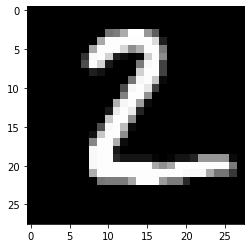

In [ ]:
images, labels = iter(test_dl).next()
image = images[0]
print(labels)
plt.imshow(image.squeeze(), cmap="gray")

In [ ]:
images.shape

torch.Size([64, 1, 28, 28])

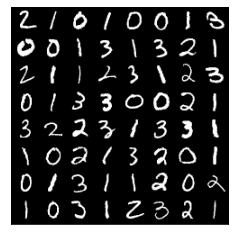

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F


plt.rcParams["savefig.bbox"] = 'tight'


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

show(torchvision.utils.make_grid(images))

In [ ]:
import pytorch_lightning as pl
#from pytorch_lightning.core.decorators import auto_move_data

class ResNetMNIST(pl.LightningModule):
  def __init__(self):
    super().__init__()
    # define model and loss
    self.model = resnet18(num_classes=4)
    self.model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    self.loss = nn.CrossEntropyLoss()

  #"@auto_move_data" # this decorator automatically handles moving your tensors to GPU if required
  def forward(self, x):
    return self.model(x)
  
  def training_step(self, batch, batch_no):
    # implement single training step
    x, y = batch
    logits = self(x)
    loss = self.loss(logits, y)
    return loss
  
  def configure_optimizers(self):
    # choose your optimizer
    return torch.optim.RMSprop(self.parameters(), lr=0.005)

In [ ]:
model = ResNetMNIST()
trainer = pl.Trainer(
    gpus=1, # use one GPU
    max_epochs=1, # set number of epochs
    progress_bar_refresh_rate=30 # set to >= 20 if running in Google Colab
)
trainer.fit(model, train_dl)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=30)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Missing logger folder: /content/lightning_logs

  | Name  | Type             | Params
-------------------------------------------
0 | model | ResNet           | 11.2 M
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
11.2 M    Trainable params
0         No

Training: 0it [00:00, ?it/s]

In [ ]:
trainer.save_checkpoint("resnet18_mnist.pt")

In [ ]:
from tqdm.autonotebook import tqdm

def get_prediction(x, model: pl.LightningModule):
  model.freeze() # prepares model for predicting
  probabilities = torch.softmax(model(x), dim=1)
  predicted_class = torch.argmax(probabilities, dim=1)
  return predicted_class, probabilities

inference_model = ResNetMNIST.load_from_checkpoint("resnet18_mnist.pt", map_location="cpu")

In [ ]:
true_y, pred_y = [], []
for batch in tqdm(iter(test_dl), total=len(test_dl)):
  x, y = batch
  true_y.extend(y)
  preds, probs = get_prediction(x, inference_model)
  pred_y.extend(preds.cpu())

  0%|          | 0/65 [00:00<?, ?it/s]

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(true_y, pred_y, digits=3))

              precision    recall  f1-score   support

           0      1.000     0.989     0.994       980
           1      0.999     0.995     0.997      1135
           2      0.988     0.985     0.987      1032
           3      0.979     0.997     0.988      1010

    accuracy                          0.992      4157
   macro avg      0.992     0.991     0.991      4157
weighted avg      0.992     0.992     0.992      4157



In [ ]:
type(inference_model)

__main__.ResNetMNIST

In [ ]:
type(inference_model.model)

torchvision.models.resnet.ResNet

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model = torch.save(inference_model.model, 'drive/MyDrive/mnist-0123-only')

In [ ]:
# load the model back and test it
model = torch.load('drive/MyDrive/mnist-0123-only')
model.eval()
# torch.no_grad()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# test against something
type(model)

torchvision.models.resnet.ResNet

In [ ]:
dataiter = iter(test_dl)
test_images, test_labels = dataiter.next()

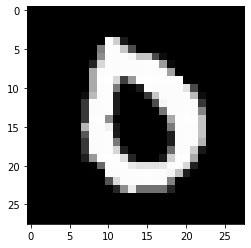

In [ ]:
image = images[6]
# https://stackoverflow.com/questions/3823752/display-image-as-grayscale-using-matplotlib
plt.imshow(image.squeeze(), cmap="gray")

In [ ]:
len(images) # should be 64 because we built the loader to issue 64 images per batch (can be thought of as per call as well)

64

In [ ]:
len(labels)

64

In [ ]:
output = model(images)

In [ ]:
_, predicted = torch.max(output, 1) # get maximum along dim 1 https://www.journaldev.com/39463/pytorch-torch-max along per row basis

In [ ]:
predicted

tensor([0, 1, 0, 2, 2, 1, 0, 1, 0, 1, 0, 0, 1, 2, 2, 2, 0, 0, 3, 2, 3, 2, 1, 0,
        0, 2, 1, 2, 0, 1, 2, 2, 3, 0, 0, 2, 2, 0, 0, 1, 3, 3, 1, 3, 2, 3, 1, 2,
        1, 0, 1, 0, 1, 1, 0, 3, 1, 0, 3, 2, 1, 2, 1, 3])

In [ ]:
labels

tensor([0, 1, 0, 2, 2, 1, 0, 1, 0, 1, 0, 0, 1, 2, 2, 2, 0, 0, 3, 2, 3, 2, 1, 0,
        0, 2, 1, 2, 0, 1, 2, 2, 3, 0, 0, 2, 2, 0, 0, 1, 3, 3, 1, 3, 2, 3, 1, 2,
        1, 0, 1, 0, 1, 1, 0, 3, 1, 0, 3, 2, 1, 2, 1, 3])